<a href="https://colab.research.google.com/github/CJWhyte/NeuromatchProject/blob/main/DataForPlasticityProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script extracts the following data from the Allen Brain Institute dataset: 

*   Inhibitory (SST and VIP) and excitatory cells
*   Passive viewing of familair and novel stim
*   0-600ms
*   Single scope recording

Note. During the 2-photon imaging portion of the experiment, mice perform the task with the same set of images they saw during training (either image set A or B), as well as an additional novel set of images (whichever of A or B that they did not see during training). This allows evaluation of the impact of different sensory contexts on neural activity - familiarity versus novelty. Sessions with familiar images include those starting with OPHYS_0, OPHYS_1, OPHYS_2, and OPHYS_3. Sessions with novel images include those starting with OPHYS_4, OPHYS_5, and OPHYS_6. To recap:

**Familiar**
*   OPHYS_0, OPHYS_1, OPHYS_2, and OPHYS_3

**Novel**
*   OPHYS_4, OPHYS_5, and OPHYS_6.


Interleaved between active behavior sessions are passive viewing sessions where mice are given their daily water ahead of the sesssion (and are thus satiated) and view the stimulus with the lick spout retracted so they are unable to earn water rewards. This allows comparison of neural activity in response to stimuli under different behavioral context - active task engagement and passive viewing without reward. Passive sessions include OPHYS_2_images_A_passive (passive session with familiar images), and OPHYS_5_images_A_passive (passive session with novel images). To recap:


Load necessary packages.

**IMPORTANT NOTE** 


*   Make sure to click restart runtime to get the script to work.
*   So as to not run out of memory we can only export one cell type at a time which we specify below.






In [1]:
# VIP, SST, Exc
celltype = 'Exc'

In [2]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

load packages

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

load summary tables

In [4]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

`Ophys_session_table`


contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.

`Behavior_session_table `

ontains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.

`Ophys_experiment_table`

contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the ophys_container_id column that can be found in both ophys_session_table and ophys_experiment_table.

**We show all three tables below**

In [5]:
ophys_session_table = cache.get_ophys_session_table()
ophys_experiment_table = cache.get_ophys_experiment_table()

We can now view the contents of each table 


In [6]:
ophys_session_table.session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B',
       'OPHYS_1_images_B', 'OPHYS_2_images_B_passive', 'OPHYS_3_images_B',
       'OPHYS_4_images_A', 'OPHYS_6_images_A', 'OPHYS_5_images_A_passive'],
      dtype=object)

We want OPHYS_2_images_A_passive (familair) and OPHYS_5_images_A_passive (novel)


In [7]:
ophys_experiment_table.session_type.unique()

array(['OPHYS_1_images_A', 'OPHYS_2_images_A_passive', 'OPHYS_3_images_A',
       'OPHYS_4_images_B', 'OPHYS_5_images_B_passive', 'OPHYS_6_images_B',
       'OPHYS_1_images_B', 'OPHYS_2_images_B_passive', 'OPHYS_3_images_B',
       'OPHYS_4_images_A', 'OPHYS_6_images_A', 'OPHYS_5_images_A_passive'],
      dtype=object)

With the conditions of each session listed above we need more information about cell type and column names in the data which we get below

In [8]:
ophys_session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


In [9]:
ophys_experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


We are now going to look at the contents of the session type dictionary to identify labels of the sessions we want


In [10]:
# Dictionary with session types
session_type = {'familiar_active': ['OPHYS_0', 'OPHYS_1', 'OPHYS_2', 'OPHYS_3'],
                'novel_active':    ['OPHYS_4', 'OPHYS_5', 'OPHYS_6'],
                'familiar_pasive': ['OPHYS_2_images_A_passive'],
                'novel_pasive':    ['OPHYS_5_images_A_passive','OPHYS_5_images_B_passive']} 

cre_line_type = ['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre']

print(f'*Ophys session types in the current dataset:*\n\n {ophys_session_table.session_type.unique()}',)      

*Ophys session types in the current dataset:*

 ['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_3_images_A'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B'
 'OPHYS_1_images_B' 'OPHYS_2_images_B_passive' 'OPHYS_3_images_B'
 'OPHYS_4_images_A' 'OPHYS_6_images_A' 'OPHYS_5_images_A_passive']


Okay! Lets load two example planes to compare familiar vs novel responses for the active condition.

In [11]:
# Active vs passive
ind_passive = (ophys_experiment_table.session_type.str.contains(session_type['familiar_pasive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][0])    |
               ophys_experiment_table.session_type.str.contains(session_type['novel_pasive'][1]))
ind_passive[ind_passive==False] = 'active'
ind_passive[ind_passive==True]  = 'pasive'
ophys_experiment_table['behavior_condition'] = ind_passive

# Familiar vs novel
fam = session_type['familiar_active'] + session_type['familiar_pasive']

i_fam = pd.Series([False]*ophys_experiment_table.shape[0])
for f in fam:
  i_fam = (i_fam | ophys_experiment_table.session_type.str.contains(f))
i_fam[i_fam==True]  = 'familiar'
i_fam[i_fam==False] = 'novel'  
ophys_experiment_table['experimental_condition'] = i_fam

We will now find a container that has both familiar and novel sessions in the active condition.

In [12]:
#-------- Containers
if celltype == 'VIP':
  i_fam = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "active" and experimental_condition == "familiar"')['ophys_container_id']
  i_nov = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "active" and experimental_condition == "novel"')['ophys_container_id']
elif celltype == 'SST':
  i_fam = ophys_experiment_table.query('cre_line == "Sst-IRES-Cre" and behavior_condition == "active" and experimental_condition == "familiar"')['ophys_container_id']
  i_nov = ophys_experiment_table.query('cre_line == "Sst-IRES-Cre" and behavior_condition == "active" and experimental_condition == "novel"')['ophys_container_id']
elif celltype == 'Exc':
  i_fam = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "familiar"')['ophys_container_id']
  i_nov = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "novel"')['ophys_container_id']

# Which containers are in both conditions for all three cells
unic_fam = i_fam.unique()
i_both = []

# VIP cells
for i,row in enumerate(unic_fam):
  if (row == i_nov.values).any():
    i_both.append(i)

# Choose the first containers with fam & nov conditions 
id_contain = unic_fam[i_both[2]]



We now need to select the experiments in a specific container

In [13]:
if celltype == 'VIP':
   exper_famil = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "active" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
   exper_novel = ophys_experiment_table.query('cre_line == "Vip-IRES-Cre" and behavior_condition == "active" and experimental_condition == "novel" and ophys_container_id == @id_contain')
elif celltype == 'SST':
   exper_famil = ophys_experiment_table.query('cre_line == "Sst-IRES-Cre" and behavior_condition == "active" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
   exper_novel = ophys_experiment_table.query('cre_line == "Sst-IRES-Cre" and behavior_condition == "active" and experimental_condition == "novel" and ophys_container_id == @id_contain')
elif celltype == 'Exc':
   exper_famil = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
   exper_novel = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "active" and experimental_condition == "novel" and ophys_container_id == @id_contain')

#example header
exper_famil.head()
exper_novel.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id,behavior_condition,experimental_condition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,
879331157,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,450471,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,126.0,Slc17a7-IRES2-Cre,GCaMP6f,4.0,0,0.0,10,878918807,879037269,869781307,VisualBehavior,175,VISp,2019-05-31 19:39:45.000000,OPHYS_4_images_B,879417807,active,novel
880961028,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,450471,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,130.0,Slc17a7-IRES2-Cre,GCaMP6f,6.0,0,2.0,12,880753403,880784794,869781307,VisualBehavior,175,VISp,2019-06-04 20:08:17.000000,OPHYS_6_images_B,881007940,active,novel


From this we will load two sessions, one for familiar and one for novel

In [14]:
# Ophys experimental ID (choose the first experiment of familiar and novel conditions) for each cell type
ophys_experiment_id_fam = exper_famil.index[0]
ophys_experiment_id_nov = exper_novel.index[0]
# Download particular ophys experiments
fam_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_fam)
nov_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_nov)

behavior_ophys_experiment_871155338.nwb: 100%|██████████| 659M/659M [00:19<00:00, 33.8MMB/s]
behavior_ophys_experiment_879331157.nwb: 100%|██████████| 841M/841M [00:26<00:00, 31.9MMB/s]


With this data now in hand we need to streucture it into a convenient format

In [15]:
metadata_keys = [
    'ophys_experiment_id',
    'ophys_session_id',
    'targeted_structure',
    'imaging_depth',
    'equipment_name',
    'cre_line',
    'mouse_id',
    'sex',
]

In [16]:
fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)
nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)

for metadata_key in metadata_keys:
  fam_experiment_neural_data[metadata_key] = fam_experiment.metadata[metadata_key]
  nov_experiment_neural_data[metadata_key] = nov_experiment.metadata[metadata_key]

fam_experiment_neural_data.head()
nov_experiment_neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,2.96064,0.352842,0.0,0.0,1080865141,1086516471,879331157,878918807,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
1,2.99295,0.208990,0.0,0.0,1080865141,1086516471,879331157,878918807,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
2,3.02526,0.183658,0.0,0.0,1080865141,1086516471,879331157,878918807,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
3,3.05757,0.229167,0.0,0.0,1080865141,1086516471,879331157,878918807,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
4,3.08988,0.044120,0.0,0.0,1080865141,1086516471,879331157,878918807,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F


We now grab the cell IDs. We will only use one cell for the time being

In [17]:
# define is member function for python
def ismember(A, B):
    return np.array([ np.sum(a == B) for a in A ])


cell_ids_fam = fam_experiment_neural_data['cell_specimen_id'].unique() 
cell_ids_nov = nov_experiment_neural_data['cell_specimen_id'].unique()

# Choose only one neuron ID
cell_id_index = ismember(cell_ids_fam,cell_ids_nov)

print('there are {} unique cells'.format(len(cell_id_index)))
print('cell ids are: {}'.format(cell_id_index))

# use this to index into cell_ids_fam
cell_id_index = cell_id_index.astype(bool)
cell_id = cell_ids_fam[cell_id_index]
# take first 6 cells
cell_id = cell_id[0:6]

print(cell_id)


there are 65 unique cells
cell ids are: [0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0
 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0]
[1086524443, 1086511673, 1086514843, 1086511342, 1086513889, 1086516471]
Categories (65, int64): [1086545833, 1086524443, 1086511120, 1086511673, ..., 1086521562, 1086552435,
                         1086552911, 1086553368]


In [18]:
# for example plots of full time series
fam_single_cell_timeseries = fam_experiment_neural_data.query('cell_specimen_id == @cell_id[0]')
nov_single_cell_timeseries = nov_experiment_neural_data.query('cell_specimen_id == @cell_id[0]')

fam_single_cell_timeseries.head(5)
# nov_single_cell_timeseries.head(5)

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,3.07988,0.151635,0.0,0.0,1080865032,1086524443,871155338,870377774,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
1,3.11219,0.220917,0.0,0.0,1080865032,1086524443,871155338,870377774,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
2,3.14449,0.109367,0.0,0.0,1080865032,1086524443,871155338,870377774,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
3,3.17680,-0.023083,0.0,0.0,1080865032,1086524443,871155338,870377774,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F
4,3.20910,0.204382,0.0,0.0,1080865032,1086524443,871155338,870377774,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,450471,F


Beautiful. Each neuron has three varieties of traces. 

`dff column` is the calcium fluorescence signal, normalized to background fluorescence.

`events column` is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in Visual Behavior whitepaper).

`filtered_events` column is events smoothed with a half-gaussian kernel.

We plot the deltaF/F time series for the full duration of the experiment below

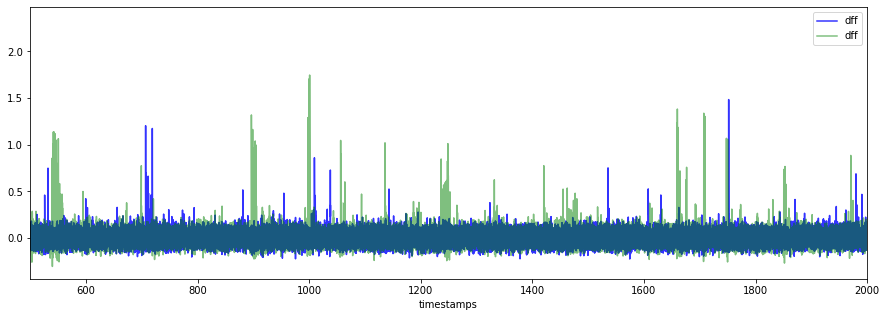

In [19]:
fig, ax = plt.subplots(figsize=(15,5))

fam_single_cell_timeseries.plot(
    x = 'timestamps',
    y = ['dff'],
    ax = ax,
    color='blue',
    alpha = 0.8
)

nov_single_cell_timeseries.plot(
    x = 'timestamps',
    y = ['dff'],
    ax = ax,
    color='green',
    alpha = 0.5
)

ax.axes.axes.set_xlim(500,2000);


All we need now is to load the stimulus data into memory

In [20]:
fam_stimulus_table = fam_experiment.stimulus_presentations
nov_stimulus_table = nov_experiment.stimulus_presentations

fam_stimulus_table.head(-1)
# nov_stimulus_table.head(10)

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25018,18002.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17987,305.86494,306.11512,False
1,0.25020,18047.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18032,306.61553,306.86573,False
2,0.25014,18092.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18077,307.36651,307.61665,False
3,0.25000,NaN,8,omitted,omitted,0,True,18121,308.10035,308.35035,False
4,0.25020,18182.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18167,308.86737,309.11757,False
...,...,...,...,...,...,...,...,...,...,...,...
4803,0.25019,234135.0,5,im062,Natural_Images_Lum_Matched_set_training_2017.0...,4642,False,234120,3911.07323,3911.32342,True
4804,0.25021,234180.0,5,im062,Natural_Images_Lum_Matched_set_training_2017.0...,4643,False,234165,3911.82382,3912.07403,False
4805,0.25019,234225.0,5,im062,Natural_Images_Lum_Matched_set_training_2017.0...,4644,False,234210,3912.57446,3912.82465,False


With the stimulus information and the neural data now both in memory we can create an event triggered response using the `mindscope_utilities` function.

In [22]:
if celltype == 'VIP':
  EventTimeSeries_fam_dff = np.zeros([117130,10])
  EventTimeSeries_fam_time = np.zeros([117130,10])
  EventTimeSeries_fam_event = np.zeros([117130,10])
elif celltype == 'SST':
  EventTimeSeries_fam_dff = np.zeros([115622,10])
  EventTimeSeries_fam_time = np.zeros([115622,10])
  EventTimeSeries_fam_event = np.zeros([115622,10])
elif celltype == 'Exc':
  EventTimeSeries_fam_dff = np.zeros([114660,10])
  EventTimeSeries_fam_time = np.zeros([114660,10])
  EventTimeSeries_fam_event = np.zeros([114660,10])

for i,cell_index in enumerate(cell_id):
  etr_fam = mindscope_utilities.event_triggered_response(
      data = fam_experiment_neural_data.query('cell_specimen_id == @cell_index'),
      t = 'timestamps',
      y = 'dff',
      event_times = fam_stimulus_table.query('is_change == False and omitted == False')['start_time'],
      t_before=0,
      t_after=.5,
      output_sampling_rate = 50,
  )

  EventTimeSeries_fam_dff[:,i] = etr_fam.dff;
  EventTimeSeries_fam_time[:,i] = etr_fam.time
  EventTimeSeries_fam_event[:,i] = etr_fam.event_number

etr_fam

,time,dff,event_number,event_time
0,0.00,0.024729,0,305.86494
1,0.02,0.012318,0,305.86494
2,0.04,-0.082062,0,305.86494
3,0.06,-0.082956,0,305.86494
4,0.08,0.004015,0,305.86494
...,...,...,...,...
114655,0.42,0.007758,4409,3914.82629
114656,0.44,0.012061,4409,3914.82629
114657,0.46,0.023560,4409,3914.82629
114658,0.48,0.119930,4409,3914.82629


In [24]:
# number of time points for each cell type
if celltype == 'VIP':
  rows = 114894;
elif celltype == 'SST':
  rows = 113880;
elif celltype == 'Exc':
  rows = 114218;


EventTimeSeries_nov_dff = np.zeros([rows,10])
EventTimeSeries_nov_time = np.zeros([rows,10])
EventTimeSeries_nov_event = np.zeros([rows,10])

for i,cell_index in enumerate(cell_id):
  etr_nov = mindscope_utilities.event_triggered_response(
      data = nov_experiment_neural_data.query('cell_specimen_id == @cell_index'),
      t = 'timestamps',
      y = 'dff',
      event_times = nov_stimulus_table.query('is_change == False and omitted == False')['start_time'],
      t_before=0,
      t_after=.5,
      output_sampling_rate = 50,
  )
  EventTimeSeries_nov_dff[:,i] = etr_nov.dff;
  EventTimeSeries_nov_time[:,i] = etr_nov.time;
  EventTimeSeries_nov_event[:,i] = etr_nov.event_number;


ALRIGHT! Lets make some plots.

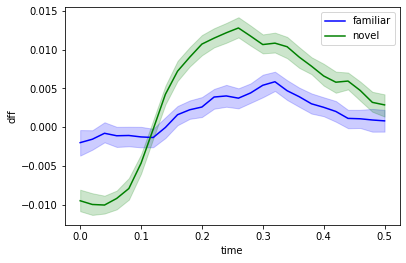

In [25]:
sns.lineplot(
    data=etr_fam,
    x='time',
    y='dff',
    n_boot=200,
    color='blue',
    label='familiar'
)
sns.lineplot(
    data=etr_nov,
    x='time',
    y='dff',
    n_boot=200,
    color='green',
    label='novel'
)

Make histogram

(array([3.81132767e-02, 7.75464937e-01, 4.82933164e+00, 8.52087473e+00,
        4.00354398e+00, 6.84059070e-01, 6.07172547e-02, 4.45479858e-03,
        8.24962699e-04, 6.59970159e-04]),
 array([-0.18071091, -0.12785133, -0.07499174, -0.02213215,  0.03072743,
         0.08358702,  0.1364466 ,  0.18930619,  0.24216577,  0.29502536,
         0.34788494]),
 <a list of 10 Patch objects>)

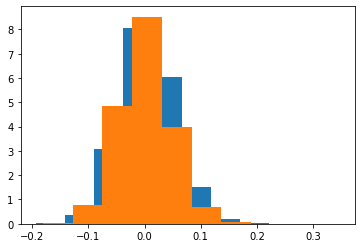

In [27]:
plt.hist(etr_nov.dff, density = True)
plt.hist(etr_fam.dff, density = True)

**Save outputs**

In [28]:
if celltype == 'VIP':
  # familiar
  np.savetxt('dff_fam_VIP.csv',EventTimeSeries_fam_dff)
  np.savetxt('time_fam_VIP.csv',EventTimeSeries_fam_time)
  np.savetxt('event_fam_VIP.csv',EventTimeSeries_fam_event)
  # novel
  np.savetxt('dff_nov_VIP.csv',EventTimeSeries_nov_dff)
  np.savetxt('time_nov_VIP.csv',EventTimeSeries_nov_time)
  np.savetxt('event_nov_VIP.csv',EventTimeSeries_nov_event)
elif celltype == 'SST':
  # familiar
  np.savetxt('dff_fam_SST.csv',EventTimeSeries_fam_dff)
  np.savetxt('time_fam_SST.csv',EventTimeSeries_fam_time)
  np.savetxt('event_fam_SST.csv',EventTimeSeries_fam_event)
  # novel
  np.savetxt('dff_nov_SST.csv',EventTimeSeries_nov_dff)
  np.savetxt('time_nov_SST.csv',EventTimeSeries_nov_time)
  np.savetxt('event_nov_SST.csv',EventTimeSeries_nov_event)
elif celltype == 'Exc':
  # familiar
  np.savetxt('dff_fam_Exc.csv',EventTimeSeries_fam_dff)
  np.savetxt('time_fam_Exc.csv',EventTimeSeries_fam_time)
  np.savetxt('event_fam_Exc.csv',EventTimeSeries_fam_event)
  # novel
  np.savetxt('dff_nov_Exc.csv',EventTimeSeries_nov_dff)
  np.savetxt('time_nov_Exc.csv',EventTimeSeries_nov_time)
  np.savetxt('event_nov_Exc.csv',EventTimeSeries_nov_event)
